# Basic Python for audio processing - ELEN6820

## 1. Introduction
There are lots of tutorials about how speech and audio processing can be done with Python, and in this tutorial we will simple focus on the necesseties that we may use in this course. For those of you who have experience on this, you can simply skip this tutorial and use any library you are comfortable with.

In this course, the usage of Python for audio processing mainly falls into 2 categories: audio I/O audio feature extraction. Visualization is also important, and we will insert that as we need. There are several libraries that we will use a lot: *Numpy/Scipy*, *Matplotlib*, [*Librosa*](https://librosa.github.io/librosa/), and [*Soundfile*](https://pysoundfile.readthedocs.io/en/0.9.0/).

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import librosa
import soundfile as sf

import warnings
warnings.filterwarnings('ignore')

## 2. Audio I/O

Personally I read audio with *librosa*, and write with *soundfile*. Writing in *librosa* could lead to trouble with specific formats in some cases. The good thing for *librosa* in reading is that if you specify another sample rate than the actual sample rate of the file, it will automatically do the resampling.

## 2.1 Reading
*librosa.load* function provides basically all you need for audio reading.

In [2]:
help(librosa.load)

Help on function load in module librosa.core.audio:

load(path, sr=22050, mono=True, offset=0.0, duration=None, dtype=<class 'numpy.float32'>, res_type='kaiser_best')
    Load an audio file as a floating point time series.
    
    Audio will be automatically resampled to the given rate
    (default `sr=22050`).
    
    To preserve the native sampling rate of the file, use `sr=None`.
    
    Parameters
    ----------
    path : string
        path to the input file.
    
        Any format supported by `audioread` will work.
    
    sr   : number > 0 [scalar]
        target sampling rate
    
        'None' uses the native sampling rate
    
    mono : bool
        convert signal to mono
    
    offset : float
        start reading after this time (in seconds)
    
    duration : float
        only load up to this much audio (in seconds)
    
    dtype : numeric type
        data type of `y`
    
    res_type : str
        resample type (see note)
    
        .. note::
           

In [3]:
y, sr = librosa.load('male1.wav', sr=8000)

And we can do some simple plotting.

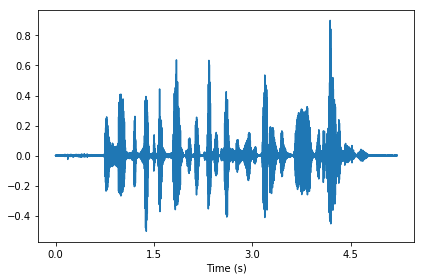

In [4]:
plt.plot(y)
# change the x-axis ticks into seconds
ticks_in_second = np.arange(len(y)) / sr
max_second = np.floor(ticks_in_second[-1])
plt.xticks(ticks=np.arange(0, (max_second+1)*sr, (max_second+1)*sr/4), 
           labels=np.arange(0, (max_second+1), (max_second+1)/4))
plt.xlabel('Time (s)')
plt.tight_layout()

With IPython notebook, there's a simple way to hear the audio file you loaded.

In [5]:
from IPython.display import Audio
Audio(y, rate=sr)

## 2.2 Writing

Always be careful when you write an audio signal to a file. As you can see below, many write functions **do not** scale the values to [-1, 1], so in some cases you need to do that manually. With *librosa*, saving an unscaled audio signal may **clip** the values to [-1, 1], which will result in severe distortion. *soundfile* won't have this problem, but just make sure you know what happens here.

In [6]:
help(sf.write)

Help on function write in module soundfile:

write(file, data, samplerate, subtype=None, endian=None, format=None, closefd=True)
    Write data to a sound file.
    
    .. note:: If `file` exists, it will be truncated and overwritten!
    
    Parameters
    ----------
    file : str or int or file-like object
        The file to write to.  See :class:`SoundFile` for details.
    data : array_like
        The data to write.  Usually two-dimensional (frames x channels),
        but one-dimensional `data` can be used for mono files.
        Only the data types ``'float64'``, ``'float32'``, ``'int32'``
        and ``'int16'`` are supported.
    
        .. note:: The data type of `data` does **not** select the data
                  type of the written file. Audio data will be
                  converted to the given `subtype`. Writing int values
                  to a float file will *not* scale the values to
                  [-1.0, 1.0). If you write the value ``np.array([42],
       

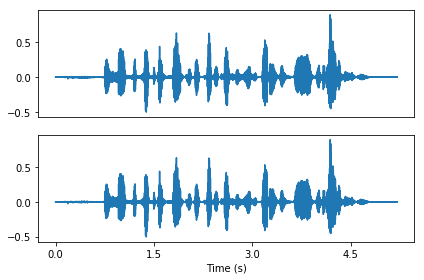

In [7]:
sf.write('male_write.wav', y, samplerate=sr)

# and we read it again for comparison
y_new, _ = librosa.load('male_write.wav', sr=8000)
plt.subplot(2,1,1)
plt.plot(y)
plt.xticks([])
plt.subplot(2,1,2)
plt.plot(y_new)
ticks_in_second = np.arange(len(y_new)) / sr
max_second = np.floor(ticks_in_second[-1])
plt.xticks(ticks=np.arange(0, (max_second+1)*sr, (max_second+1)*sr/4), 
           labels=np.arange(0, (max_second+1), (max_second+1)/4))
plt.xlabel('Time (s)')
plt.tight_layout()

## 3. Audio feature extraction

The most important audio feature is **time-frequency representation**, generated by shoft-time Fourier transform (STFT).*librosa* provides basically everything you need, and you may want to also check their documentation for some task-specific features. Here we will introduce STFT and several other time-frequency representations derived from the standard STFT.

Window size of STFT typically depends on the sample rate of the signal. In our case where the sample rate is 8kHz, window size of 256 or 512 would be enough. Hop size is generally selected to be $1/4$ of the window size.

STFT returns complex-valued spectrogram. In most of the cases, what we interested in is the **magnitude spectrogram**, the magnitude part of the complex-valued spectrogram. The reason is that in tasks such as speech recognition or event detection, we only care about the actual *contents* or the *patterns* of the signal. Magnitude spectrogram contains frequency information such as pitch (fundamental frequency), harmonics, speaker identity, etc. Phase spectrogram, on the other hand, represents **when those frequency components arrive at the current frame** (recall that different phase values for a same frequency component correpond to shifted versions of a cosine wave). In some cases where the target is to make the signa "sounds better", phase will be important, but in tasks like recognition and classification, phase is something that we typically throw away.

## 3.1 STFT and spectrogram

In [8]:
help(librosa.stft)

Help on function stft in module librosa.core.spectrum:

stft(y, n_fft=2048, hop_length=None, win_length=None, window='hann', center=True, dtype=<class 'numpy.complex64'>, pad_mode='reflect')
    Short-time Fourier transform (STFT)
    
    Returns a complex-valued matrix D such that
        `np.abs(D[f, t])` is the magnitude of frequency bin `f`
        at frame `t`
    
        `np.angle(D[f, t])` is the phase of frequency bin `f`
        at frame `t`
    
    Parameters
    ----------
    y : np.ndarray [shape=(n,)], real-valued
        the input signal (audio time series)
    
    n_fft : int > 0 [scalar]
        FFT window size
    
    hop_length : int > 0 [scalar]
        number audio of frames between STFT columns.
        If unspecified, defaults `win_length / 4`.
    
    win_length  : int <= n_fft [scalar]
        Each frame of audio is windowed by `window()`.
        The window will be of length `win_length` and then padded
        with zeros to match `n_fft`.
    
        I

In [9]:
spec = librosa.stft(y, n_fft=256, hop_length=64)  # complex-valued spectrogram, shape: (1 + n_fft/2, T)
mag_spec = np.abs(spec)  # magnitude spectrogram
phase_spec = np.angle(spec)  # phase spectrogram
reconstruct_spec = mag_spec * np.exp(phase_spec * 1j)
print(np.allclose(spec, reconstruct_spec))

True


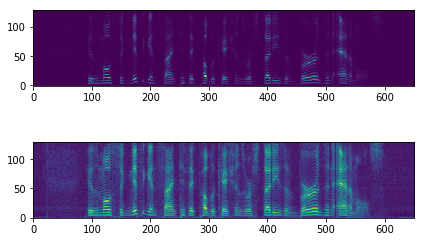

In [10]:
# visualization
plt.subplot(2,1,1)
plt.imshow(mag_spec, origin='lower')
# to make it smoother, typically we use the power of 1/3 for visualization
plt.subplot(2,1,2)
plt.imshow(mag_spec**.33, origin='lower')
plt.tight_layout()

The harmonic patterns, salient/silent regions and the transitions can be better visualized. We can also take a look at the phase spectrogram, although it will basically look like a random matrix:

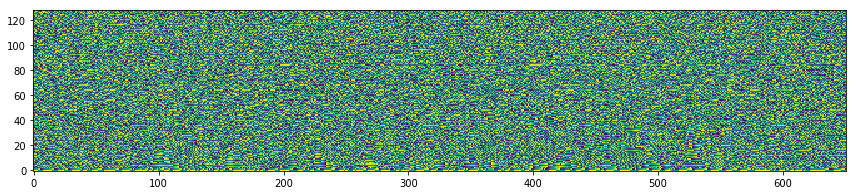

In [11]:
plt.figure(figsize=(12,6))
plt.imshow(phase_spec, origin='lower')
plt.tight_layout()

You may now have an intuition about why we typically don't care about phase.

## 3.2 Log-power spectrogram, Mel-spectrogram, MFCC

The actual feature to be used in most of the tasks is not the standard magnitude spectrogram. One reason is that magnitude spectrogram itself pays **equal attention** to all the frequency components, while we human beings have our preferences to specific frequency range or a more **compact** and representative feature. There are also some features that particularly designed for special tasks, e.g. [Chromagram](https://labrosa.ee.columbia.edu/matlab/chroma-ansyn/) for musical chord recognition and [Tempogram](https://ieeexplore.ieee.org/abstract/document/5495219) for tempo estimation. Here we will include some most widely-used features in recent years.

**Log-power spectrogram** is simply the logarithm of the power spectrogram. Power spectrogram is the square of magnitude spectrogram that represents the power distribution of different frequency components. Typically log-power spectrogram is represented in decibel scale.

Note that there are two terms *spectrogram* and *spectrum*. Spectrogram is a time-frequency representation that splits a signal into small chunks/segments, and sepctrum is the frequency analysis on that entire signal. So generally you can treat spectrogram as a concatenation of the spectrums of each small segment in the entire signal.

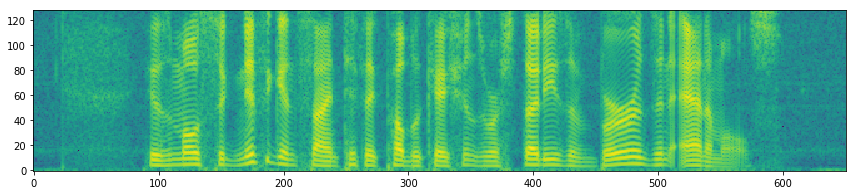

In [12]:
log_power_spec = 10*np.log10(mag_spec**2)  # dB scale
plt.figure(figsize=(12,6))
plt.imshow(log_power_spec, origin='lower')
plt.tight_layout()

**Mel-spectrogram** is a type of representation that rescales the magnitude spectrogram into a more human-friendly frequency preferences. This is done by a set of mel-frequency filterbanks that concentrate more on the lower frequency range. Mel-frequency scale is related to how human perceive pitch across different frequency ranges. For detailed definition of mel scale, the [Wiki page](https://en.wikipedia.org/wiki/Mel_scale) serves as an useful information.

In [13]:
help(librosa.filters.mel)

Help on function mel in module librosa.filters:

mel(sr, n_fft, n_mels=128, fmin=0.0, fmax=None, htk=False, norm=1)
    Create a Filterbank matrix to combine FFT bins into Mel-frequency bins
    
    Parameters
    ----------
    sr        : number > 0 [scalar]
        sampling rate of the incoming signal
    
    n_fft     : int > 0 [scalar]
        number of FFT components
    
    n_mels    : int > 0 [scalar]
        number of Mel bands to generate
    
    fmin      : float >= 0 [scalar]
        lowest frequency (in Hz)
    
    fmax      : float >= 0 [scalar]
        highest frequency (in Hz).
        If `None`, use `fmax = sr / 2.0`
    
    htk       : bool [scalar]
        use HTK formula instead of Slaney
    
    norm : {None, 1, np.inf} [scalar]
        if 1, divide the triangular mel weights by the width of the mel band
        (area normalization).  Otherwise, leave all the triangles aiming for
        a peak value of 1.0
    
    Returns
    -------
    M         : np.nda

The *librosa.filters.mel* creates a set of **mel-filterbanks**. The parameters show that we can set the number of filters (*n_mels*), and the minimum and maximum frequency that the filterbank spans to (*fmin* and *fmax*). The number of filters varies from sample rate to different tasks.

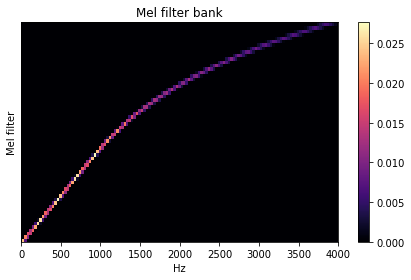

In [14]:
mel_filterbank = librosa.filters.mel(sr, n_fft=256, n_mels=64)

# this visualization script comes from librosa document: https://librosa.github.io/librosa/generated/librosa.filters.mel.html#librosa.filters.mel
from librosa.display import specshow
plt.figure()
specshow(mel_filterbank, x_axis='linear', sr=sr)
plt.ylabel('Mel filter')
plt.title('Mel filter bank')
plt.colorbar()
plt.tight_layout()

What we can learn from it is that the frequency response for the filters has a piece-wise linear behavior below and above around 1.5kHz. This means that for lower frequency parts, the filters have **higher resolution** - more than half of the filters focus on the frequency range below $sr/2$. In frequency domain, you can expect something like this: (image source: https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html)

![mel](https://haythamfayek.com/assets/posts/post1/mel_filters.jpg)

So in frequency domain, they look like many triangles, and the width becomes larger when it comes to higher frequency range.

Mel-filterbank is typically applied to a power spectrum, and this is simply a multiplication operation:

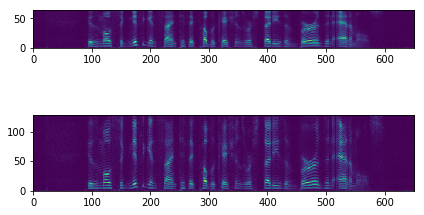

In [15]:
plt.subplot(2,1,1)
power_spec = mag_spec**2
mel_spec = np.dot(mel_filterbank, power_spec)
plt.imshow(mel_spec**.33, origin='lower')
# compare with the original magnitude spectrogram
plt.subplot(2,1,2)
plt.imshow(power_spec**.33, origin='lower')
plt.tight_layout()

We can see that the feature is more compact, and some of the high-frequency information is lost. With *librosa*, you can also use *librosa.feature.melspectrogram* to directly generate the mel-spectrogram:

In [16]:
help(librosa.feature.melspectrogram)  # note that the default is to apply on power spectrum

Help on function melspectrogram in module librosa.feature.spectral:

melspectrogram(y=None, sr=22050, S=None, n_fft=2048, hop_length=512, power=2.0, **kwargs)
    Compute a mel-scaled spectrogram.
    
    If a spectrogram input `S` is provided, then it is mapped directly onto
    the mel basis `mel_f` by `mel_f.dot(S)`.
    
    If a time-series input `y, sr` is provided, then its magnitude spectrogram
    `S` is first computed, and then mapped onto the mel scale by
    `mel_f.dot(S**power)`.  By default, `power=2` operates on a power spectrum.
    
    Parameters
    ----------
    y : np.ndarray [shape=(n,)] or None
        audio time-series
    
    sr : number > 0 [scalar]
        sampling rate of `y`
    
    S : np.ndarray [shape=(d, t)]
        spectrogram
    
    n_fft : int > 0 [scalar]
        length of the FFT window
    
    hop_length : int > 0 [scalar]
        number of samples between successive frames.
        See `librosa.core.stft`
    
    power : float > 0 [scalar

In [17]:
direct_mel_spec = librosa.feature.melspectrogram(y, sr=sr, n_fft=256, hop_length=64, n_mels=64)
np.allclose(direct_mel_spec, mel_spec)

True

**MFCC** stands for **Mel-frequency cepstral coefficients**, and it is perhaps one of the most widely-used features for speech recognition. The term *cepstrum* is another feature derived from *spectrum* by inverting the first four letters, and this feature was originally designed for pitch tracking in speech and audio. The calculation of cepstrum is by applying inverse FFT (IFFT) on the logarithm of FFT. I won't go deeper into this feature, and for those of you who are interested in this, [this slide](http://research.cs.tamu.edu/prism/lectures/sp/l9.pdf) can help you a lot.

The design for MFCC various a little bit in different implementations or tasks, but the general procedure contains mainly 4 stages:
1. Calculate the mel-scale spectrum (**Mel-frequency** part)
2. Calculate the logarithm of the mel-spectrum above (**cepstral** part)
3. Calculate a discrete cosine transform (DCT) on the log-mel-spec above (**cepstral** part)
4. Take the amplitudes of the feature above as the output (**coefficient** part)

Note that in step 3, a DCT is applied instead of the IFFT in cepstrum. There are reasons for that, but again I won't talk about it more since it will be a long story. For now you can simply remenber that. The slide above also contains a little bit discussion about it.

*librosa.feature.mfcc* can directly generate the MFCC feature:

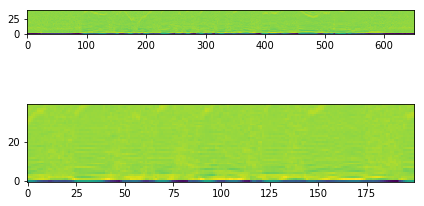

In [18]:
MFCC = librosa.feature.mfcc(y=y, sr=sr, n_fft=256, hop_length=64, n_mfcc=40)
plt.subplot(2,1,1)
plt.imshow(MFCC, origin='lower')
# visualize part of it
plt.subplot(2,1,2)
plt.imshow(MFCC[:,200:400], origin='lower')
plt.tight_layout()

Now you cannot see that obvious harmonic-like patterns. But well, this is really useful for speech recognition. Sometimes people use **delta** and **double-delta** features, and this actually means the local derivative ($f_{t}-f_{t-1}$) of feature $f$ along a selected axis (typically the time axis). *librosa.feature.delta* calculates delta feature for any time-frequency representation, but note that there is an optional feature smoothing method (e.g. moving average is a type of smoothing) called [**Savitsky-Golay filtering**](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) applied to the delta feature in this function.

In [19]:
help(librosa.feature.delta)

Help on function delta in module librosa.feature.utils:

delta(data, width=9, order=1, axis=-1, trim=<DEPRECATED parameter>, mode='interp', **kwargs)
    Compute delta features: local estimate of the derivative
    of the input data along the selected axis.
    
    Delta features are computed Savitsky-Golay filtering.
    
    Parameters
    ----------
    data      : np.ndarray
        the input data matrix (eg, spectrogram)
    
    width     : int, positive, odd [scalar]
        Number of frames over which to compute the delta features.
        Cannot exceed the length of `data` along the specified axis.
        If `mode='interp'`, then `width` must be at least `data.shape[axis]`.
    
    order     : int > 0 [scalar]
        the order of the difference operator.
        1 for first derivative, 2 for second, etc.
    
    axis      : int [scalar]
        the axis along which to compute deltas.
        Default is -1 (columns).
    
    trim      : bool [DEPRECATED]
        This para

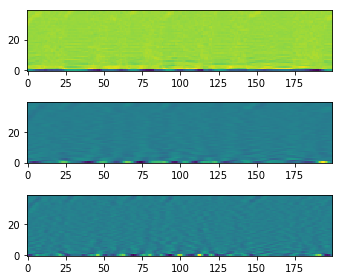

In [20]:
MFCC_delta = librosa.feature.delta(MFCC)
MFCC_delta2 = librosa.feature.delta(MFCC, order=2)

plt.subplot(3,1,1)
plt.imshow(MFCC[:,200:400], origin='lower')
plt.subplot(3,1,2)
plt.imshow(MFCC_delta[:,200:400], origin='lower')
plt.subplot(3,1,3)
plt.imshow(MFCC_delta2[:,200:400], origin='lower')
plt.tight_layout()

# 4. Conclusion

Basically this concludes this short tutorial. If you are interested in more about Python for speech and audio, there are also other more comprehensive tutorials:
- [Python for Scientific Audio](https://github.com/faroit/awesome-python-scientific-audio#tutorials)
- [Selected Topics in Audio Signal Processing](https://github.com/spatialaudio/selected-topics-in-audio-signal-processing-exercises)
- [Basic Sound Processing in Python](https://www.youtube.com/watch?v=0ALKGR0I5MA)
- [Python and sounds](https://www.coursera.org/lecture/audio-signal-processing/python-and-sounds-p4oGc)